<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

from scipy.stats import loguniform

from skopt.space import Real

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy

In [4]:
from library.utils.ownModels.majorityClassModel import MajorityClassClassifier # Importing self-developed model object
from library.utils.ownModels.neuralNets.feedForward import FeedForwardNeuralNetwork

In [5]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [6]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/model_evaluation/results.csv"

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

## Pipeline Selection
We will having pipelines for:
- ensembled_models (random forest, gradient boosting)
- tree-based (decision trees)
- support vectors machines (non-linear*)
- naive bayes (gaussian naive bayes)
- stacking (stacking models)


* We originally conceived to add linear for the sake of model diversity. While the theory already pointed us out that the linear SVM wont be able to find the separating hyperplane (i.e., model is able to fit), we wanted to see if by setting

In [7]:
default_pipeline = ensembled_pipeline = tree_pipeline = supportVectorsMachine_pipeline = baseline_pipeline = naiveBayes_pipeline = stacking_pipeline = feedForwardNN_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        results_path=results_path,
                        model_type="classification")

In [8]:
pipelines = {
            "not-baseline": {
                  "ensembled": ensembled_pipeline,
                  "tree-based": tree_pipeline,
                  "linear": supportVectorsMachine_pipeline,
                  "naive-bayes": naiveBayes_pipeline,
                  "feedForwardNN": feedForwardNN_pipeline,
                  "stacking": stacking_pipeline,
                  }, 
            "baseline": {
                  "baselines": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [9]:
baseline_pipeline.dataset.example_attribute = "1"

In [10]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [11]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [12]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [13]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x284925f50>, 'tree-based': <library.pipeline.pipeline.Pipeline object at 0x284925f50>, 'linear': <library.pipeline.pipeline.Pipeline object at 0x284925f50>, 'naive-bayes': <library.pipeline.pipeline.Pipeline object at 0x284925f50>, 'feedForwardNN': <library.pipeline.pipeline.Pipeline object at 0x284925f50>, 'stacking': <library.pipeline.pipeline.Pipeline object at 0x284925f50>}, 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline object at 0x284925f50>, 'example': <library.pipeline.pipeline.Pipeline object at 0x284fef810>}}


In [14]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 10816756240. You are at automatic feature selection!


In [15]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 10814119760
Hello, world! from 10821236752


{'not-baseline': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [16]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 10771793872. You are at automatic feature selection!
Whats good from 10816756240. You are at automatic feature selection!


{'not-baseline': {'ensembled': None}, 'baseline': {'example': None}}

In [17]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [18]:
pipeline_manager.pipelines

{'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'naive-bayes': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'feedForwardNN': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x284925f50>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x284925f50>}}

<hr>

# Start Of The Pipeline

In [19]:
default_pipeline.dataset.df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Hash,Category,Family,reboot
0,31053,2448,14044,23472,74824,2452,0,8919,4786,4132,...,1635,2351,3285,1551,11221,193,f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...,Trojan_SMS,opfake,before
1,107787,21976,11852,74548,69052,23152,0,25341,20965,4375,...,1816,826,1544,2045,8457,189,556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...,Trojan_SMS,opfake,before
2,86584,18460,12284,59992,91548,19376,0,24500,21378,3121,...,2244,3406,1565,2819,10780,195,398322f94b5bfa2a9e7b3756a4cf409764595003280c48...,Trojan_SMS,fakeinst,before
3,41248,924,10328,36280,55768,928,0,10082,7281,2800,...,974,4134,3138,1556,11739,191,4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...,Trojan_SMS,fakeinst,before
4,38621,5080,12392,27388,71048,5088,0,9077,5750,3326,...,936,2298,3752,1992,10488,188,6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...,Trojan_SMS,fakeinst,before


In [20]:
for col in default_pipeline.dataset.df.columns.to_list():
    print(col)

Memory_PssTotal
Memory_PssClean
Memory_SharedDirty
Memory_PrivateDirty
Memory_SharedClean
Memory_PrivateClean
Memory_SwapPssDirty
Memory_HeapSize
Memory_HeapAlloc
Memory_HeapFree
Memory_Views
Memory_ViewRootImpl
Memory_AppContexts
Memory_Activities
Memory_Assets
Memory_AssetManagers
Memory_LocalBinders
Memory_ProxyBinders
Memory_ParcelMemory
Memory_ParcelCount
Memory_DeathRecipients
Memory_OpenSSLSockets
Memory_WebViews
API_Process_android.os.Process_start
API_Process_android.app.ActivityManager_killBackgroundProcesses
API_Process_android.os.Process_killProcess
API_Command_java.lang.Runtime_exec
API_Command_java.lang.ProcessBuilder_start
API_JavaNativeInterface_java.lang.Runtime_loadLibrary
API_JavaNativeInterface_java.lang.Runtime_load
API_WebView_android.webkit.WebView_loadUrl
API_WebView_android.webkit.WebView_loadData
API_WebView_android.webkit.WebView_loadDataWithBaseURL
API_WebView_android.webkit.WebView_addJavascriptInterface
API_WebView_android.webkit.WebView_evaluateJavascript

In [21]:
default_pipeline.dataset.df["Category"].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

In [22]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [23]:
default_pipeline.data_preprocessing.remove_duplicates()

No duplicates found in the dataset


In [24]:
default_pipeline.data_preprocessing.get_missing_values()

No missing values found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/phases/dataset/split/strategies/noTimeSeries.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


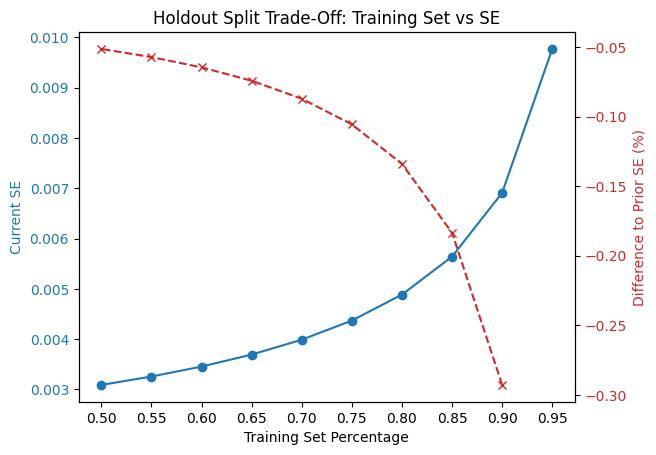

,train_size (%),train_size_count,validation_size (%),validation_size_count,test_size (%),test_size_coount,currentSE,differenceToPriorSE,differenceToPriorSE (%)
0,0.95,50767.0,0.025,1336.0,0.025,1336.0,0.009769,0.009769,inf
1,0.90,48095.0,0.050,2672.0,0.050,2672.0,0.006908,-0.002861,-0.292893
2,0.85,45423.0,0.075,4008.0,0.075,4008.0,0.005640,-0.001268,-0.183503
3,0.80,42751.0,0.100,5344.0,0.100,5344.0,0.004885,-0.000756,-0.133975
4,0.75,40079.0,0.125,6680.0,0.125,6680.0,0.004369,-0.000516,-0.105573
5,0.70,37407.0,0.150,8016.0,0.150,8016.0,0.003988,-0.000381,-0.087129
6,0.65,34735.0,0.175,9352.0,0.175,9352.0,0.003692,-0.000296,-0.074180
7,0.60,32063.0,0.200,10688.0,0.200,10688.0,0.003454,-0.000238,-0.064586
8,0.55,29391.0,0.225,12024.0,0.225,12024.0,0.003256,-0.000198,-0.057191
9,0.50,26720.0,0.250,13360.0,0.250,13360.0,0.003089,-0.000167,-0.051317


In [25]:
default_pipeline.dataset.split.asses_split_classifier(p=.85, step=.05, plot=True)

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [26]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   plot_distribution=False)

In [27]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

<hr>

# 3. DATA PREPROCESSING

<hr>

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [28]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="baselines")

In [29]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


In [30]:
default_pipeline.data_preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [31]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [32]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [33]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


### Outliers 

In [34]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [35]:
featuresToEncode = ["Reboot"]

In [36]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)
encoded_maps_perPipeline

Pipeline baselines in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}
Pipeline ensembled in category not-baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}


{'not-baseline': {'ensembled': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'No_Category': 3,
   'PUA': 4,
   'Ransomware': 5,
   'Riskware': 6,
   'Scareware': 7,
   'Trojan': 8,
   'Trojan_Banker': 9,
   'Trojan_Dropper': 10,
   'Trojan_SMS': 11,
   'Trojan_Spy': 12,
   'Zero_Day': 13}},
 'baseline': {'baselines': {'Adware': 0,
   'Backdoor': 1,
   'FileInfector': 2,
   'No_Category': 3,
   'PUA': 4,
   'Ransomware': 5,
   'Riskware': 6,
   'Scareware': 7,
   'Trojan': 8,
   'Trojan_Banker': 9,
   'Trojan_Dropper': 10,
   'Trojan_SMS': 11,
   'Trojan_Spy': 12,
   'Zero_Day': 13}}}

In [37]:
pipeline_manager.pipelines_analysis.encoded_map = encoded_maps_perPipeline["baseline"]["baselines"] # setting baseline as an arbitrary example (all are the same as for now)

Lets visualize the results of the encoding...

In [38]:
default_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,-0.572982,-0.212739,3.662252,-0.680374,-0.269575,-0.304846,0.0,-0.744642,-0.903544,-0.190928,...,0.0,0.0,1.229024,0.414508,-0.328646,-0.232606,1.436909,1.088923,-0.50,1
10388,0.223136,0.310774,-2.933775,0.225135,-0.211834,0.196228,0.0,-0.345350,-0.408902,-0.166667,...,-0.5,2.0,-0.712401,-0.995337,0.449479,-0.162513,0.420610,-0.788685,0.25,0
11029,1.298399,1.525006,-0.046358,1.288786,1.902038,1.401289,0.0,1.092089,1.166345,0.800281,...,-0.5,1.0,0.200000,0.486528,-0.559896,-0.995327,0.742376,-0.324044,1.50,0
36609,-0.407325,-0.136850,3.000000,-0.495674,0.071505,-0.239198,0.0,-0.469555,-0.483883,-0.511955,...,1.0,2.0,0.147757,-0.969430,-0.633854,-0.031672,0.475289,-0.801008,0.50,0
26413,0.097281,-0.192834,0.099338,0.481453,0.522524,-0.129864,0.0,0.760766,0.679752,1.106188,...,0.0,0.0,0.120317,2.872539,-0.715625,-0.098131,-0.980547,0.405826,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,-0.562982,-0.382433,0.543046,-0.389446,-1.457991,-0.475531,0.0,-0.748509,-0.895085,-0.247890,...,0.0,1.0,-0.127704,-0.263212,-0.177083,-0.367082,-0.841220,-1.202073,-0.25,1
36008,-0.192939,-0.072157,2.847682,-0.232845,0.407222,-0.058009,0.0,-0.160779,-0.123270,-0.399437,...,0.0,0.0,-1.018470,0.315026,-0.623958,0.314642,2.321241,0.449797,0.75,0
46265,-0.526820,-0.179895,3.112583,-0.588366,-0.299428,-0.280019,0.0,-0.681523,-0.782819,-0.369198,...,1.0,1.0,0.812137,1.255440,-0.403646,-0.323988,0.519453,0.743873,-0.25,1
23587,1.155789,2.092560,0.198675,0.827551,0.464247,1.995942,0.0,1.539293,1.188190,3.105837,...,1.0,0.0,-0.589446,0.521762,-0.255208,-0.055556,1.700315,0.457079,-0.75,1


In [39]:
default_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

In [40]:
baseline_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,35115,2936,12944,25560,83552,3072,0,9086,5558,3527,...,3,0,4372,2820,1369,1567,4737,14865,188,1
10388,71418,11352,8960,46700,84844,11468,0,15178,11581,3596,...,2,2,693,99,2863,1702,2804,8161,191,0
11029,120450,30872,10704,71532,132144,31660,0,37109,30762,6346,...,2,1,2422,2959,925,98,3416,9820,196,0
36609,42669,4156,12544,29872,91184,4172,0,13283,10668,2614,...,5,2,2323,149,783,1954,2908,8117,192,0
26413,65679,3256,10792,52684,101276,6004,0,32054,24837,7216,...,3,0,2271,7564,626,1826,139,12426,192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,35571,208,11060,32352,56960,212,0,9027,5661,3365,...,3,1,1801,1512,1660,1308,404,6685,189,1
36008,52445,5196,12452,36008,98696,7208,0,17994,15059,2934,...,3,0,113,2628,802,2621,6419,12583,193,0
46265,37220,3464,12612,27708,82884,3488,0,10049,7028,3020,...,5,1,3582,4443,1225,1391,2992,13633,189,1
23587,113947,39996,10852,60764,99972,41624,0,43932,31028,12903,...,5,0,926,3027,1510,1908,5238,12609,187,1


In [41]:
baseline_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [42]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [43]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [44]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [45]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [46]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [47]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [48]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Support Vector Machines models
nonLinearSupportVectorModel = SVC()
linearSupportVectorModel = LinearSVC()

# Naive Bayes model
naiveBayesModel = GaussianNB()

# Neural Network model
neuralNetworkModel = FeedForwardNeuralNetwork(X_shape=default_pipeline.dataset.X_train.shape, y_shape=default_pipeline.dataset.y_train.shape)

# Baseline models
logisticRegressionModel = LogisticRegression()
majorityClassModel = MajorityClassClassifier()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [49]:
pipeline_manager.pipelines

{'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'naive-bayes': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'feedForwardNN': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x284925f50>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x1775b9d50>}}

Pipelines always need to diverge from training onwards. Otherwise they will have each other results (which does not follow the isolation pattern we have programmed this with)

In [50]:
# Ensembled models
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="ensembled")

# Support Vector Machines models
supportVectorsMachine_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="linear")

# Naive Bayes model
naiveBayes_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="naive-bayes")

# Stacking model
stacking_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="stacking")

# Feed Forward Neural Network model
feedForwardNN_pipeline = pipeline_manager.create_pipeline_divergence(category="not-baseline", pipelineName="feedForwardNN")


In [51]:
pipeline_manager.pipelines

{'not-baseline': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x285131d50>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x284925f50>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x285196050>,
  'naive-bayes': <library.pipeline.pipeline.Pipeline at 0x2850fa610>,
  'feedForwardNN': <library.pipeline.pipeline.Pipeline at 0x2851c98d0>,
  'stacking': <library.pipeline.pipeline.Pipeline at 0x28515be90>},
 'baseline': {'baselines': <library.pipeline.pipeline.Pipeline at 0x1775b9d50>}}

In [52]:
# Ensembled models
ensembled_pipeline.modelling.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.modelling.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.modelling.add_model("Decision Tree", decisionTreeModel)

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.add_model("Non-Linear SVM", nonLinearSupportVectorModel) 
supportVectorsMachine_pipeline.modelling.add_model("Linear SVM", linearSupportVectorModel) 

# Naive Bayes
naiveBayes_pipeline.modelling.add_model("Gaussian Naive Bayes", naiveBayesModel)

# Stacking model (delayed till models are optimized)

# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.add_model("Feed Forward NN", neuralNetworkModel, model_type="neuralNetwork")

# Baseline
baseline_pipeline.modelling.add_model("Logistic Regression (baseline)", logisticRegressionModel)
baseline_pipeline.modelling.add_model("Majority Class (baseline)", majorityClassModel)


#### THIS WILL BE DELETED
While we debug, lets exlclude some models we dont need for now (they are very slow to train).

#### THIS WONT BE DELETED
As indicated throughout the notebook this is the part where we eliminate the models that have been excluded from the final training.

| Model | Reason for Exclusion |
|-------|----------------------|
|Linear SVM | Ran the training for 1h never converged| 

In [53]:
# Ensembled models
ensembled_pipeline.modelling.models_to_exclude = ["Gradient Boosting", "Random Forest"]

# Tree-based models
tree_pipeline.modelling.models_to_exclude = []

# Support Vector Machines models
supportVectorsMachine_pipeline.modelling.models_to_exclude = ["Linear SVM", "Non-Linear SVM"]

# Naive Bayes models
naiveBayes_pipeline.modelling.models_to_exclude = []

# Feed Forward Neural Network model
feedForwardNN_pipeline.modelling.models_to_exclude = []

# Baseline models
baseline_pipeline.modelling.models_to_exclude = ["Logistic Regression (baseline)"]


Lets finally start fitting the models:

In [54]:
pipeline_manager.pipeline_state = "pre"

In [55]:
pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models",
                                       verbose=False, 
                                       exclude_pipeline_names=["stacking"],
                                       current_phase=pipeline_manager.pipeline_state)

Skipping pipeline stacking in category not-baseline because it is in the exclude list
All models have been fitted and made predictions in parallel.
All models have been fitted and made predictions in parallel.
=> Fitting Majority Class (baseline) model
Sklearn model: <library.utils.ownModels.majorityClassModel.MajorityClassClassifier object at 0x17960ea10>
!> Started fitting Majority Class (baseline)
Lenght of X_data: 42751
		 => Fitted Majority Class (baseline). Took 0.0035228729248046875 seconds
=> Predicting Majority Class (baseline) model
!> Started predicting Majority Class (baseline)
		 => Predicted Majority Class (baseline). Took 7.581710815429688e-05 seconds
Fitted and predicted model Majority Class (baseline)
=> Fitting Decision Tree model
=> Fitting Gaussian Naive Bayes model
Sklearn model: DecisionTreeClassifier()
!> Started fitting Decision Tree
Lenght of X_data: 42751
Sklearn model: GaussianNB()
!> Started fitting Gaussian Naive Bayes
Lenght of X_data: 42751
		 => Fitted G

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


=> Fitting Feed Forward NN model
Sklearn model: <library.utils.ownModels.neuralNets.feedForward.FeedForwardNeuralNetwork object at 0x156f854d0>
!> Started fitting Feed Forward NN
Lenght of X_data: 42751
Epoch 1/2
8551/8551 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.2525 - f1_score: 0.0020 - loss: 7.4315 - val_accuracy: 0.2650 - val_f1_score: 4.0228e-05 - val_loss: 2.2775
Epoch 2/2
8551/8551 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.2681 - f1_score: 4.0055e-05 - loss: 2.1920 - val_accuracy: 0.2650 - val_f1_score: 4.0228e-05 - val_loss: 2.1568
Restoring model weights from the end of the best epoch: 2.
		 => Fitted Feed Forward NN. Took 42.371962785720825 seconds
=> Predicting Feed Forward NN model
!> Started predicting Feed Forward NN
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Soft predictions done
Hard predictions done
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Soft predictions done
Hard predictions done
		 => Predicted Feed Forward NN. Took 10.490685224533081 seconds
Fitted an

{'not-baseline': {'ensembled': None,
  'linear': None,
  'naive-bayes': None,
  'tree-based': None,
  'feedForwardNN': None},
 'baseline': {'baselines': None}}

Let's make sure the predictions vary between holdout sets

In [56]:
pipeline_manager.pipelines["not-baseline"]["feedForwardNN"].modelling.list_of_models["Feed Forward NN"].tuning_states["pre"].assesment["model_sklearn"].model

<Sequential name=sequential, built=True>

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [57]:
comments = "wiLL THIS work?"

In [58]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       verbose=False,
                                                       exclude_pipeline_names=["stacking"],
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

Skipping pipeline stacking in category not-baseline because it is in the exclude list
All models have been evaluated.
All models have been evaluated.
Evaluating model Decision Tree
Evaluating Decision Tree in pre phase
Evaluating model Majority Class (baseline)
Evaluating Majority Class (baseline) in pre phase
Evaluating model Gaussian Naive Bayes
Evaluating Gaussian Naive Bayes in pre phase
METRIC RESULTS FOR Decision Tree => F1: 0.7593269021846899, Precision: 0.7581719802755515, Recall: 0.7610404191616766, Accuracy: 0.7610404191616766
METRIC RESULTS FOR Majority Class (baseline) => F1: 0.1110052085178755, Precision: 0.07020913263293772, Recall: 0.26497005988023953, Accuracy: 0.26497005988023953
METRIC RESULTS FOR Gaussian Naive Bayes => F1: 0.37141832537728453, Precision: 0.6136586971584927, Recall: 0.32092065868263475, Accuracy: 0.32092065868263475


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

All models have been evaluated.
****WARNING****: A model with the same values already exists in the results. Results will not be saved. 
                               You tried to write {'id': '9f8f37e5cbc8ca0eba4c0c03dc6b513b3c25c1f8a0f5683d5ebc7ac81c8a8b93', 'timeStamp': '2025-04-29 19:00:00', 'comments': 'wiLL THIS work?', 'modelName': 'Decision Tree', 'currentPhase': 'pre', 'features_used': ['Memory_PssTotal', 'Memory_PssClean', 'Memory_SharedDirty', 'Memory_PrivateDirty', 'Memory_SharedClean', 'Memory_PrivateClean', 'Memory_SwapPssDirty', 'Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree', 'Memory_Views', 'Memory_ViewRootImpl', 'Memory_AppContexts', 'Memory_Activities', 'Memory_Assets', 'Memory_AssetManagers', 'Memory_LocalBinders', 'Memory_ProxyBinders', 'Memory_ParcelMemory', 'Memory_ParcelCount', 'Memory_DeathRecipients', 'Memory_OpenSSLSockets', 'Memory_WebViews', 'API_Process_android.os.Process_start', 'API_Process_android.app.ActivityManager_killBackgroundProcesses', 

/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: Undefined

All models have been evaluated.


## Performance Evaluation 
Below are shown all the metrics we can compare our plots to:

### Cross-Model Evaluation (pre-tuning)

In [59]:
pipeline_manager.pipelines_analysis._compute_classification_report()

,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support,precision,recall,f1-score,support
Adware,0.798985,0.790161,0.794548,996.0,0.794595,0.14759,0.248942,996.0,0.0,0.0,0.0,996.0,0.0,0.0,0.0,996.0
Backdoor,0.669811,0.633929,0.651376,112.0,0.115646,0.151786,0.131274,112.0,0.0,0.0,0.0,112.0,0.0,0.0,0.0,112.0
FileInfector,0.8,0.64,0.711111,25.0,0.018533,0.92,0.036335,25.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0
No_Category,0.431138,0.347826,0.385027,207.0,0.115385,0.014493,0.025751,207.0,0.0,0.0,0.0,207.0,0.0,0.0,0.0,207.0
PUA,0.743802,0.737705,0.740741,122.0,0.197605,0.270492,0.228374,122.0,0.0,0.0,0.0,122.0,0.0,0.0,0.0,122.0
Ransomware,0.771588,0.780282,0.77591,355.0,0.332767,0.552113,0.415254,355.0,0.0,0.0,0.0,355.0,0.0,0.0,0.0,355.0
Riskware,0.83931,0.859463,0.849267,1416.0,0.754197,0.444209,0.559111,1416.0,0.26497,1.0,0.418935,1416.0,0.26497,1.0,0.418935,1416.0
Scareware,0.701299,0.72,0.710526,75.0,0.065104,0.666667,0.118624,75.0,0.0,0.0,0.0,75.0,0.0,0.0,0.0,75.0
Trojan,0.802002,0.811937,0.806939,888.0,0.845333,0.356982,0.501979,888.0,0.0,0.0,0.0,888.0,0.0,0.0,0.0,888.0
Trojan_Banker,0.615385,0.592593,0.603774,27.0,0.060241,0.37037,0.103627,27.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,27.0


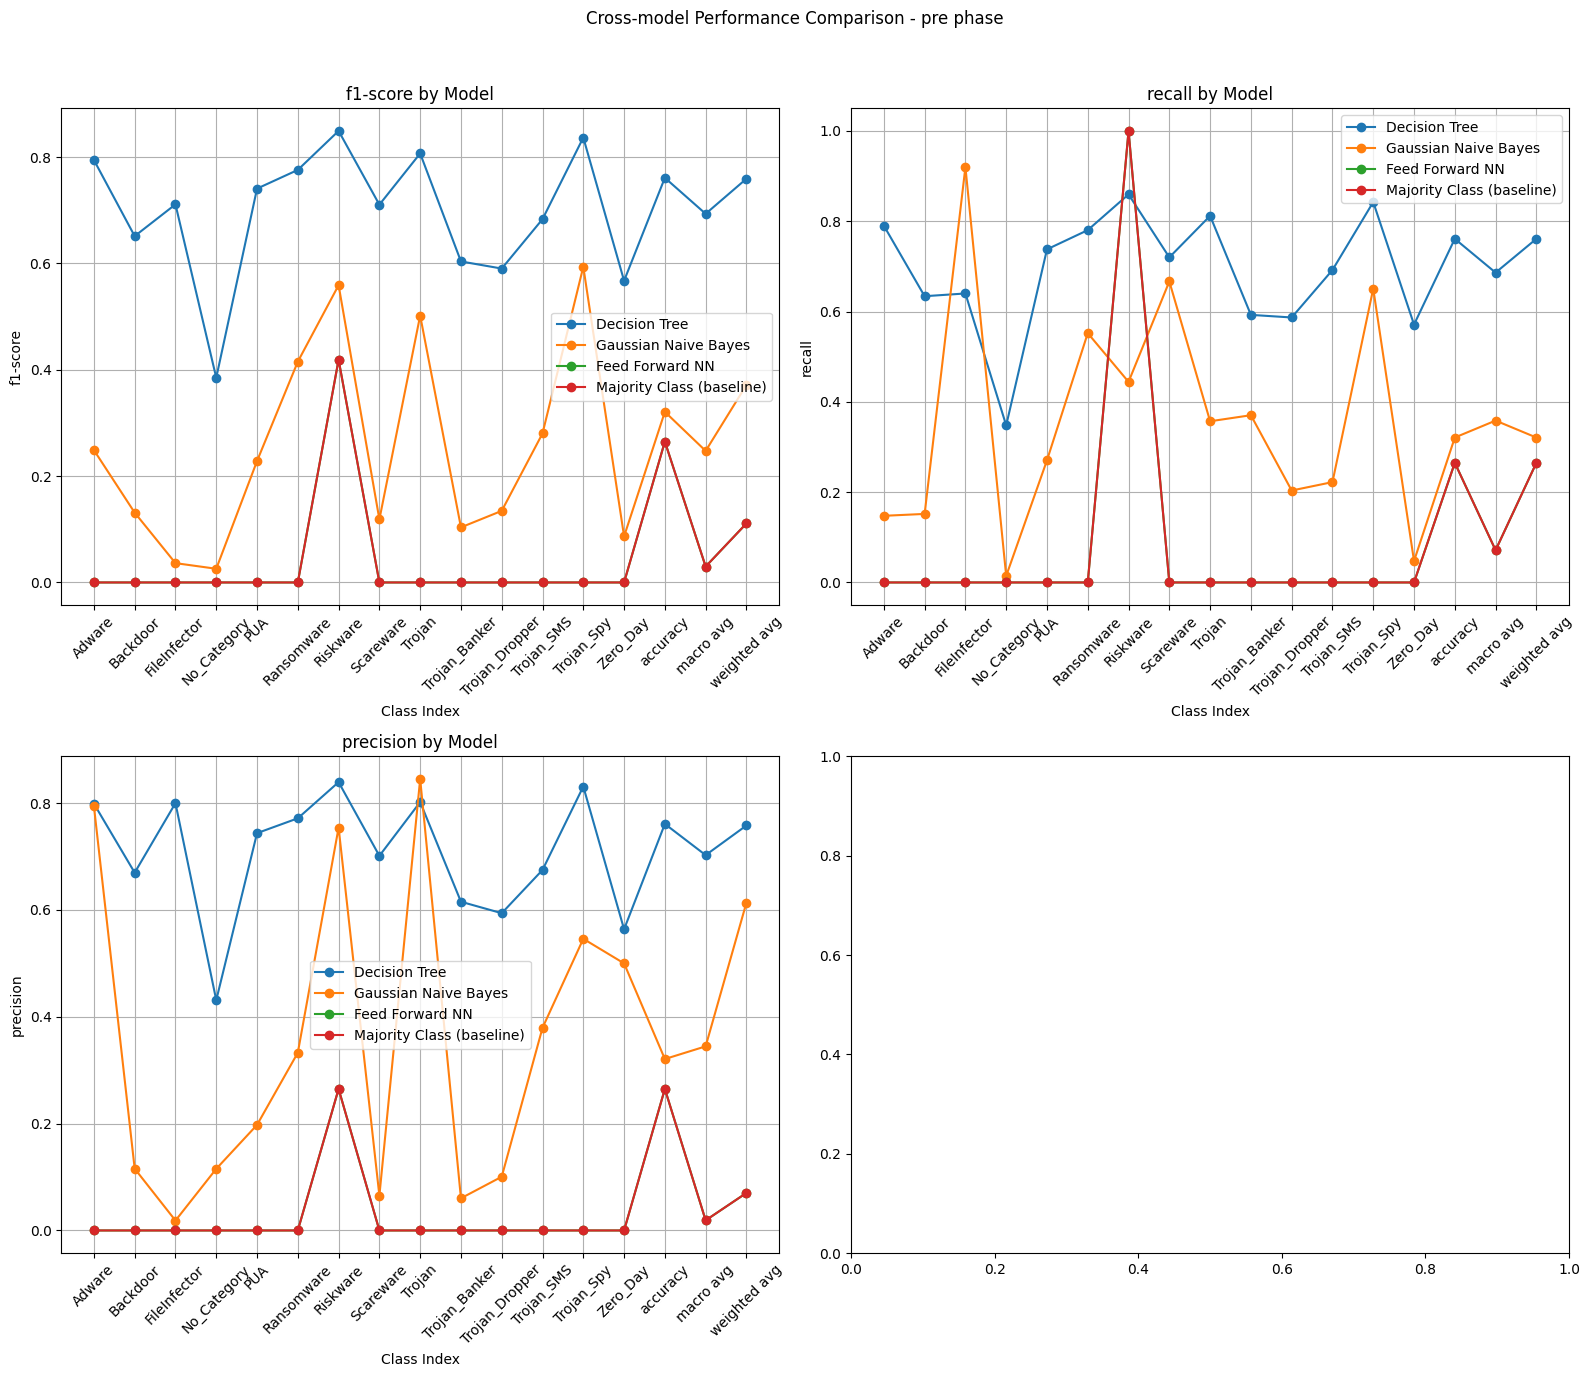

In [60]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision"])


/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")
/Users/javierdominguezsegura/Academics/College/Courses/2nd year/ML/finalProject/ml-final-project/library/pipeline/analysis/pipelines_analysis.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='modelName', y=metric, ax=ax, palette="viridis")


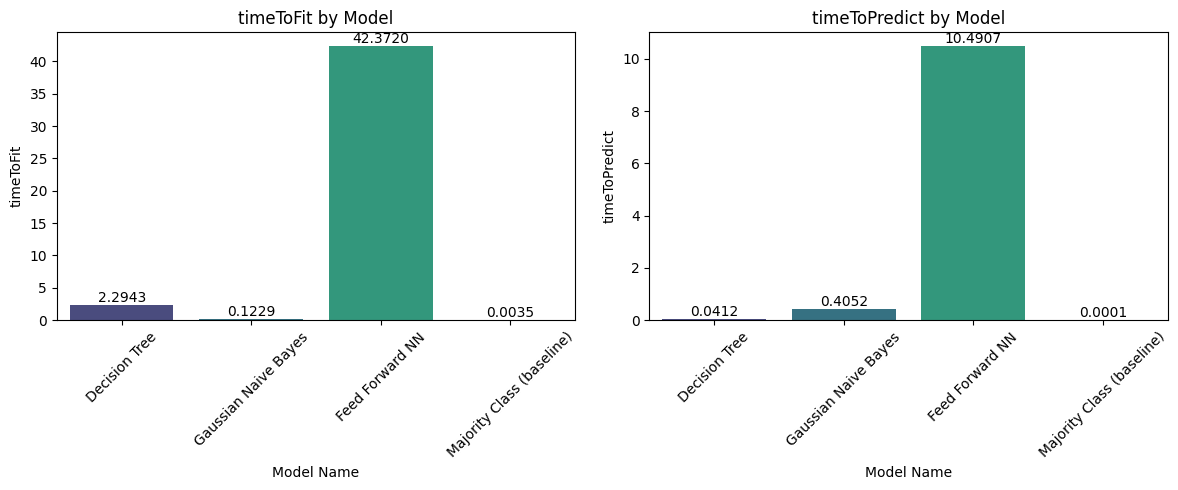

,id,timeStamp,comments,modelName,currentPhase,features_used,hyperParameters,timeToFit,timeToPredict,classification_report,accuracy_val,accuracy_test,precision_val,precision_test,recall_val,recall_test,f1-score_val,f1-score_test
0,9f8f37e5cbc8ca0eba4c0c03dc6b513b3c25c1f8a0f568...,2025-04-29 19:00:00,wiLL THIS work?,Decision Tree,pre,"[Memory_PssTotal, Memory_PssClean, Memory_Shar...","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",2.294264,0.041152,None,0.761040,-1,0.758172,-1,0.761040,-1,0.759327,-1
0,a0c7bccff0e0607a8505a238bd747be381bfe3c630d0c8...,2025-04-29 19:00:00,wiLL THIS work?,Gaussian Naive Bayes,pre,"[Memory_PssTotal, Memory_PssClean, Memory_Shar...","{'priors': None, 'var_smoothing': 1e-09}",0.122947,0.405194,None,0.320921,-1,0.613659,-1,0.320921,-1,0.371418,-1
0,1e7054b8fb27e833be1dd3d972faf33f467b28c93134e8...,2025-04-29 19:00:07,wiLL THIS work?,Feed Forward NN,pre,"[Memory_PssTotal, Memory_PssClean, Memory_Shar...","{'num_layers': 3, 'num_neurons': [1, 1, 42751]...",42.371963,10.490685,None,0.264970,-1,0.070209,-1,0.264970,-1,0.111005,-1
0,030af96d08bc8ca18153d654d8b76511728d30e0820951...,2025-04-29 19:00:00,wiLL THIS work?,Majority Class (baseline),pre,"[Memory_PssTotal, Memory_PssClean, Memory_Shar...",{},0.003523,0.000076,None,0.264970,-1,0.070209,-1,0.264970,-1,0.111005,-1


In [61]:
metrics_df = pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"])
metrics_df

### Results Summary Visualization

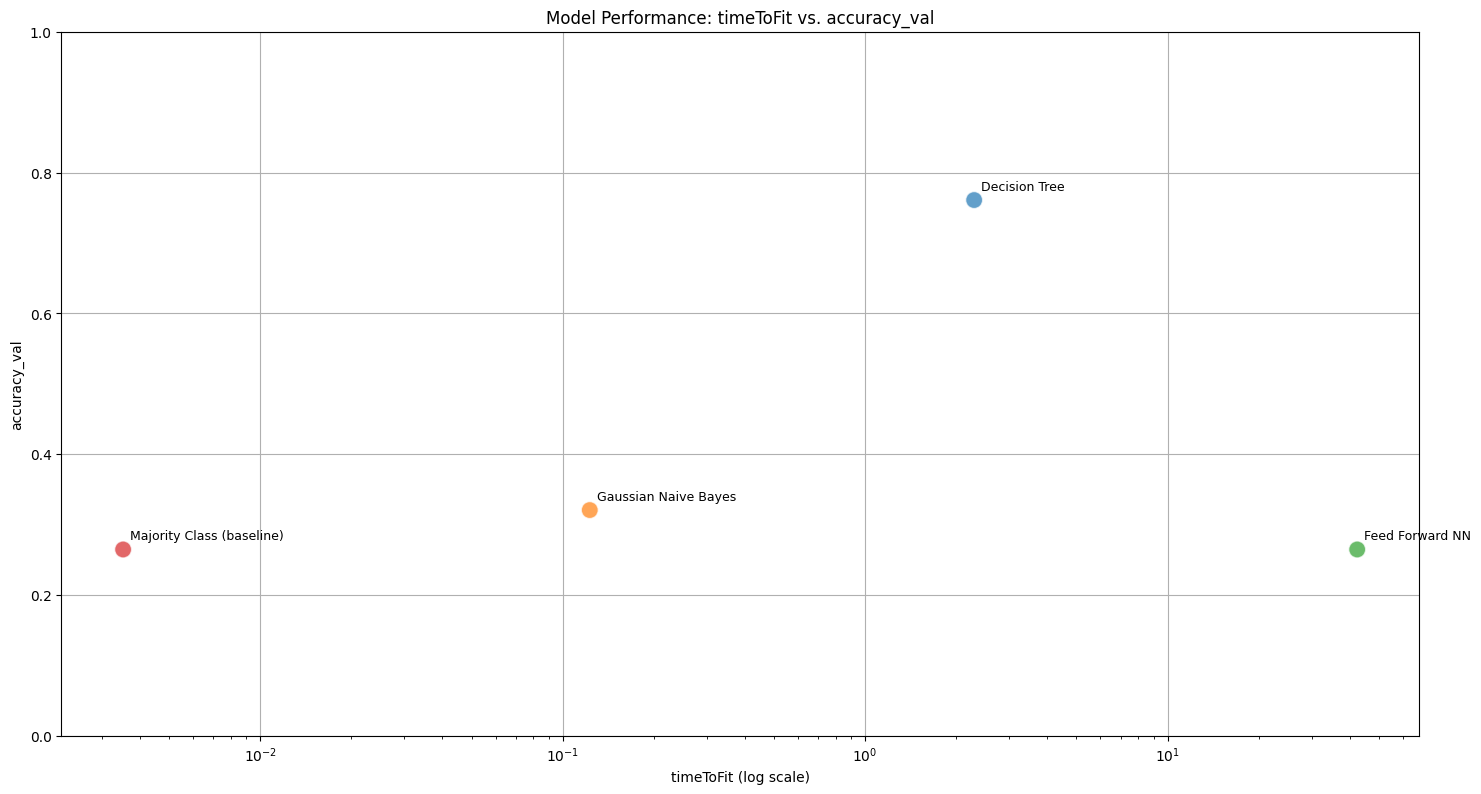

In [62]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy")

### Intra-model Evaluation (pre-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

There going to be 4 rows and 3 columns


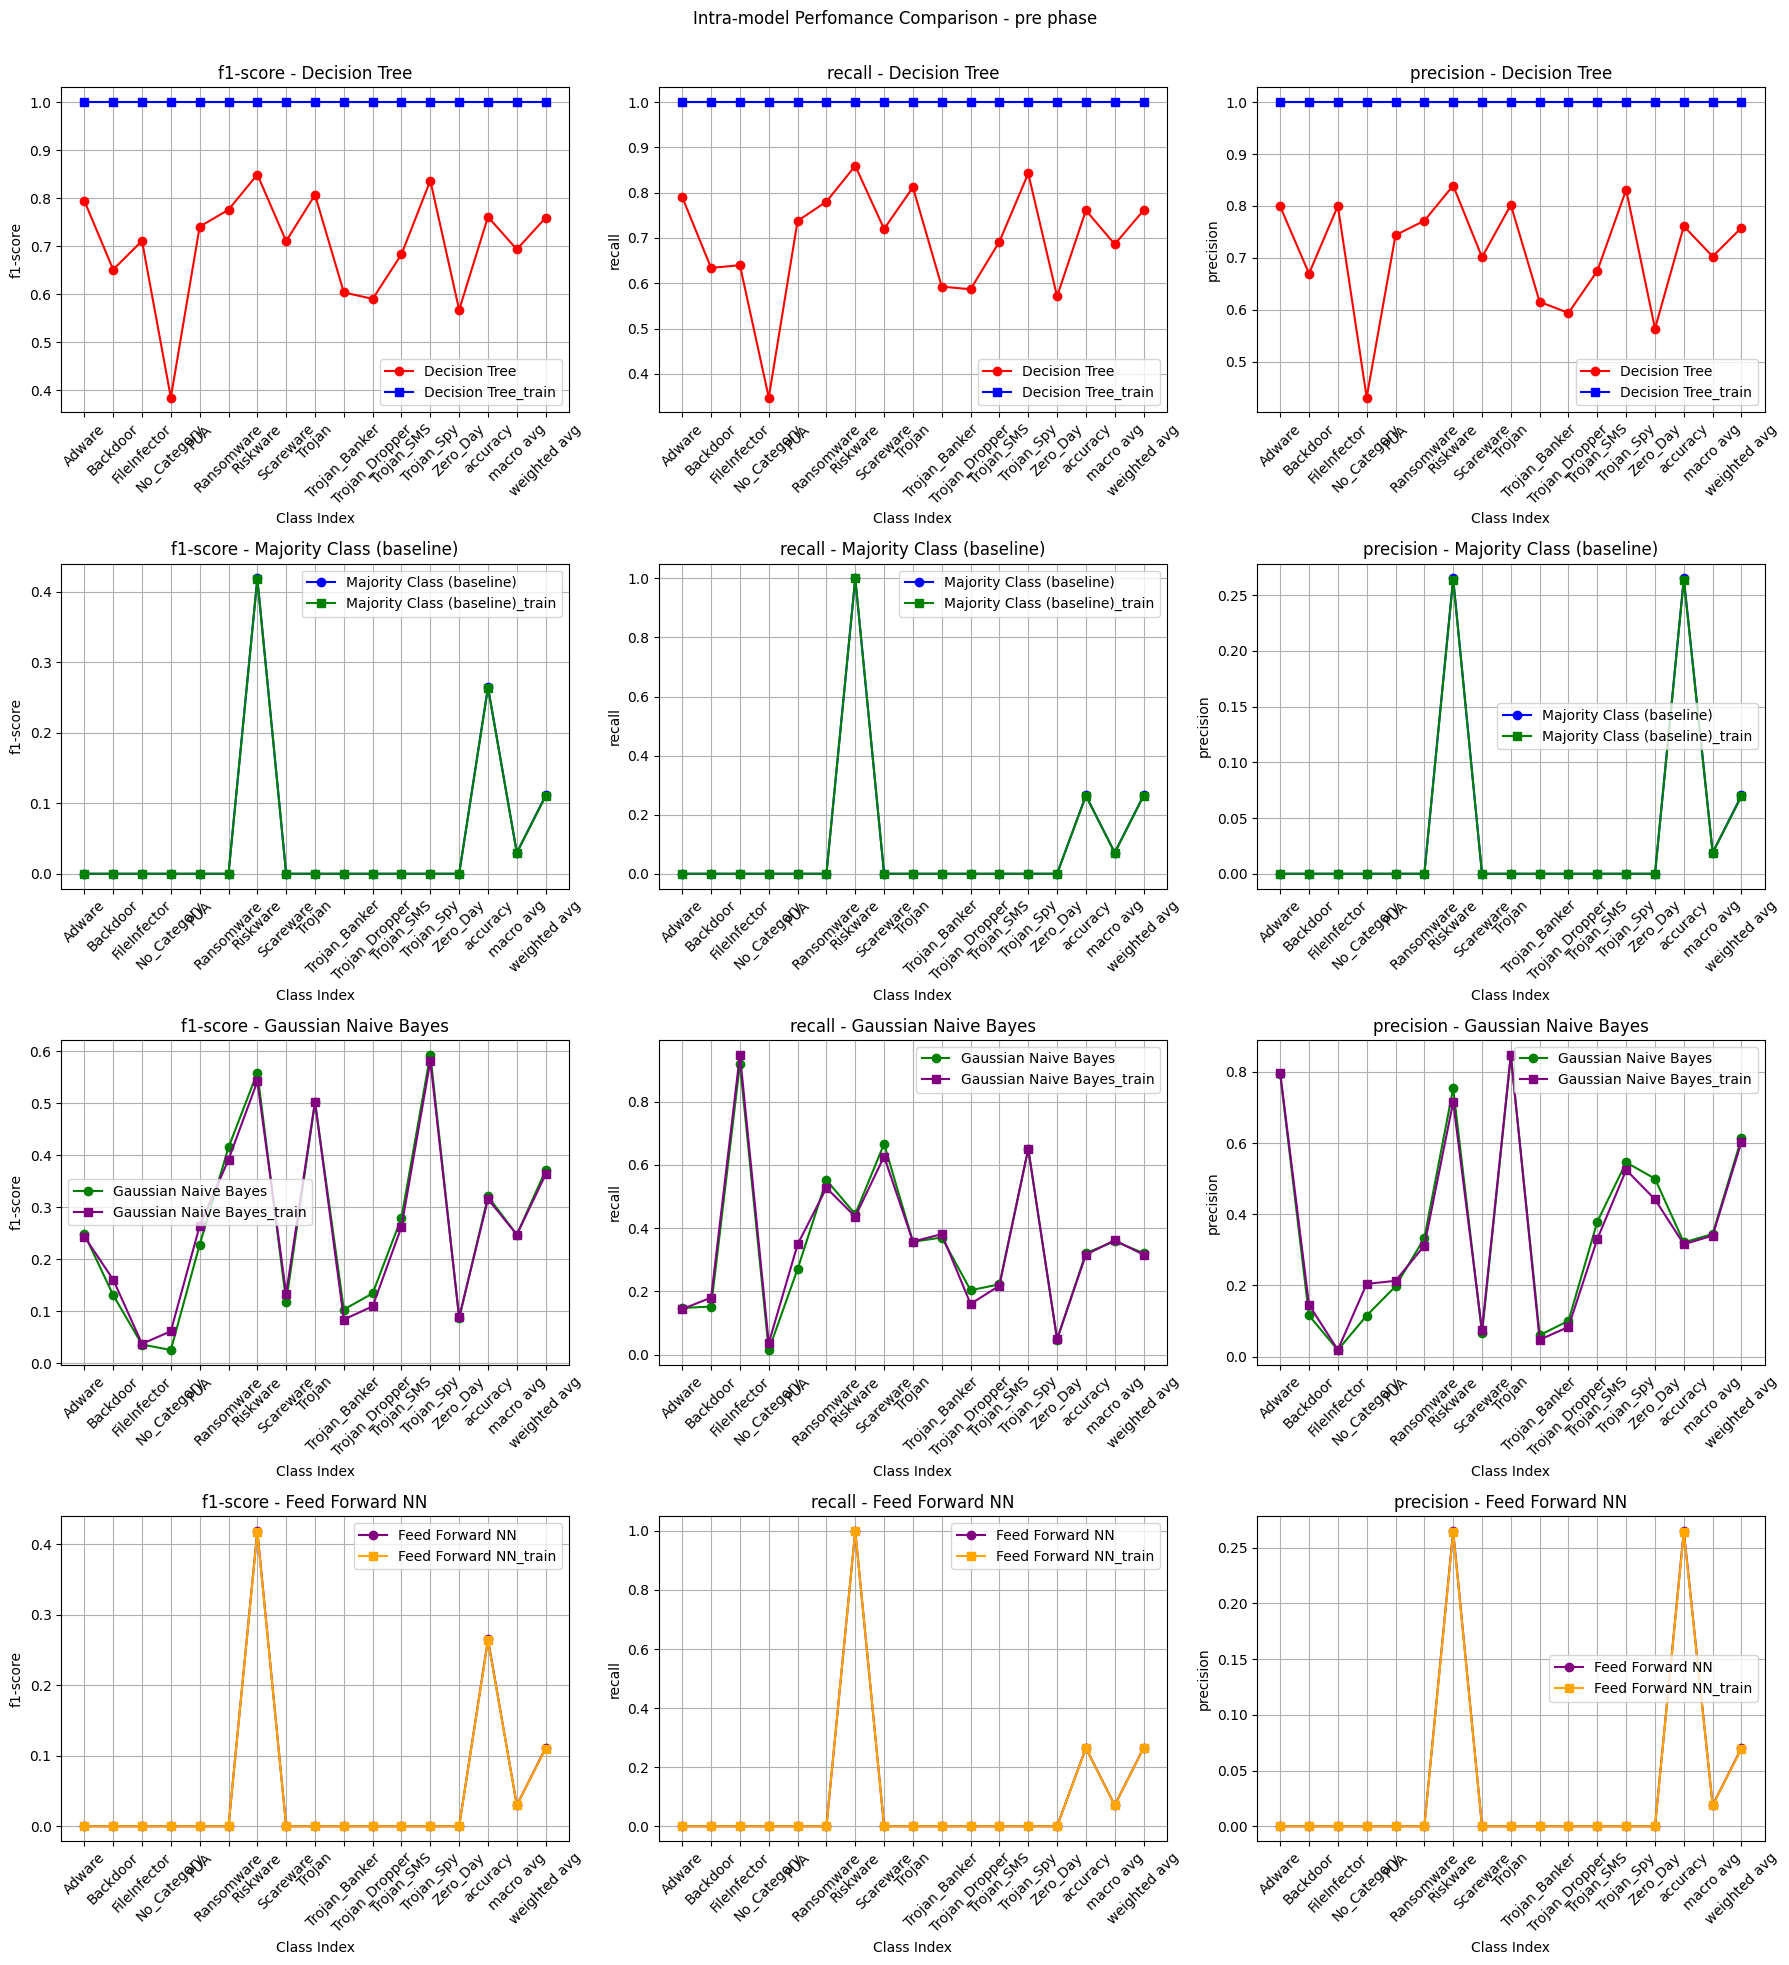

In [63]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"])

### Residual analysis (pre-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

Plotting: Decision Tree
Plotting: Gaussian Naive Bayes
Plotting: Feed Forward NN
Plotting: Majority Class (baseline)


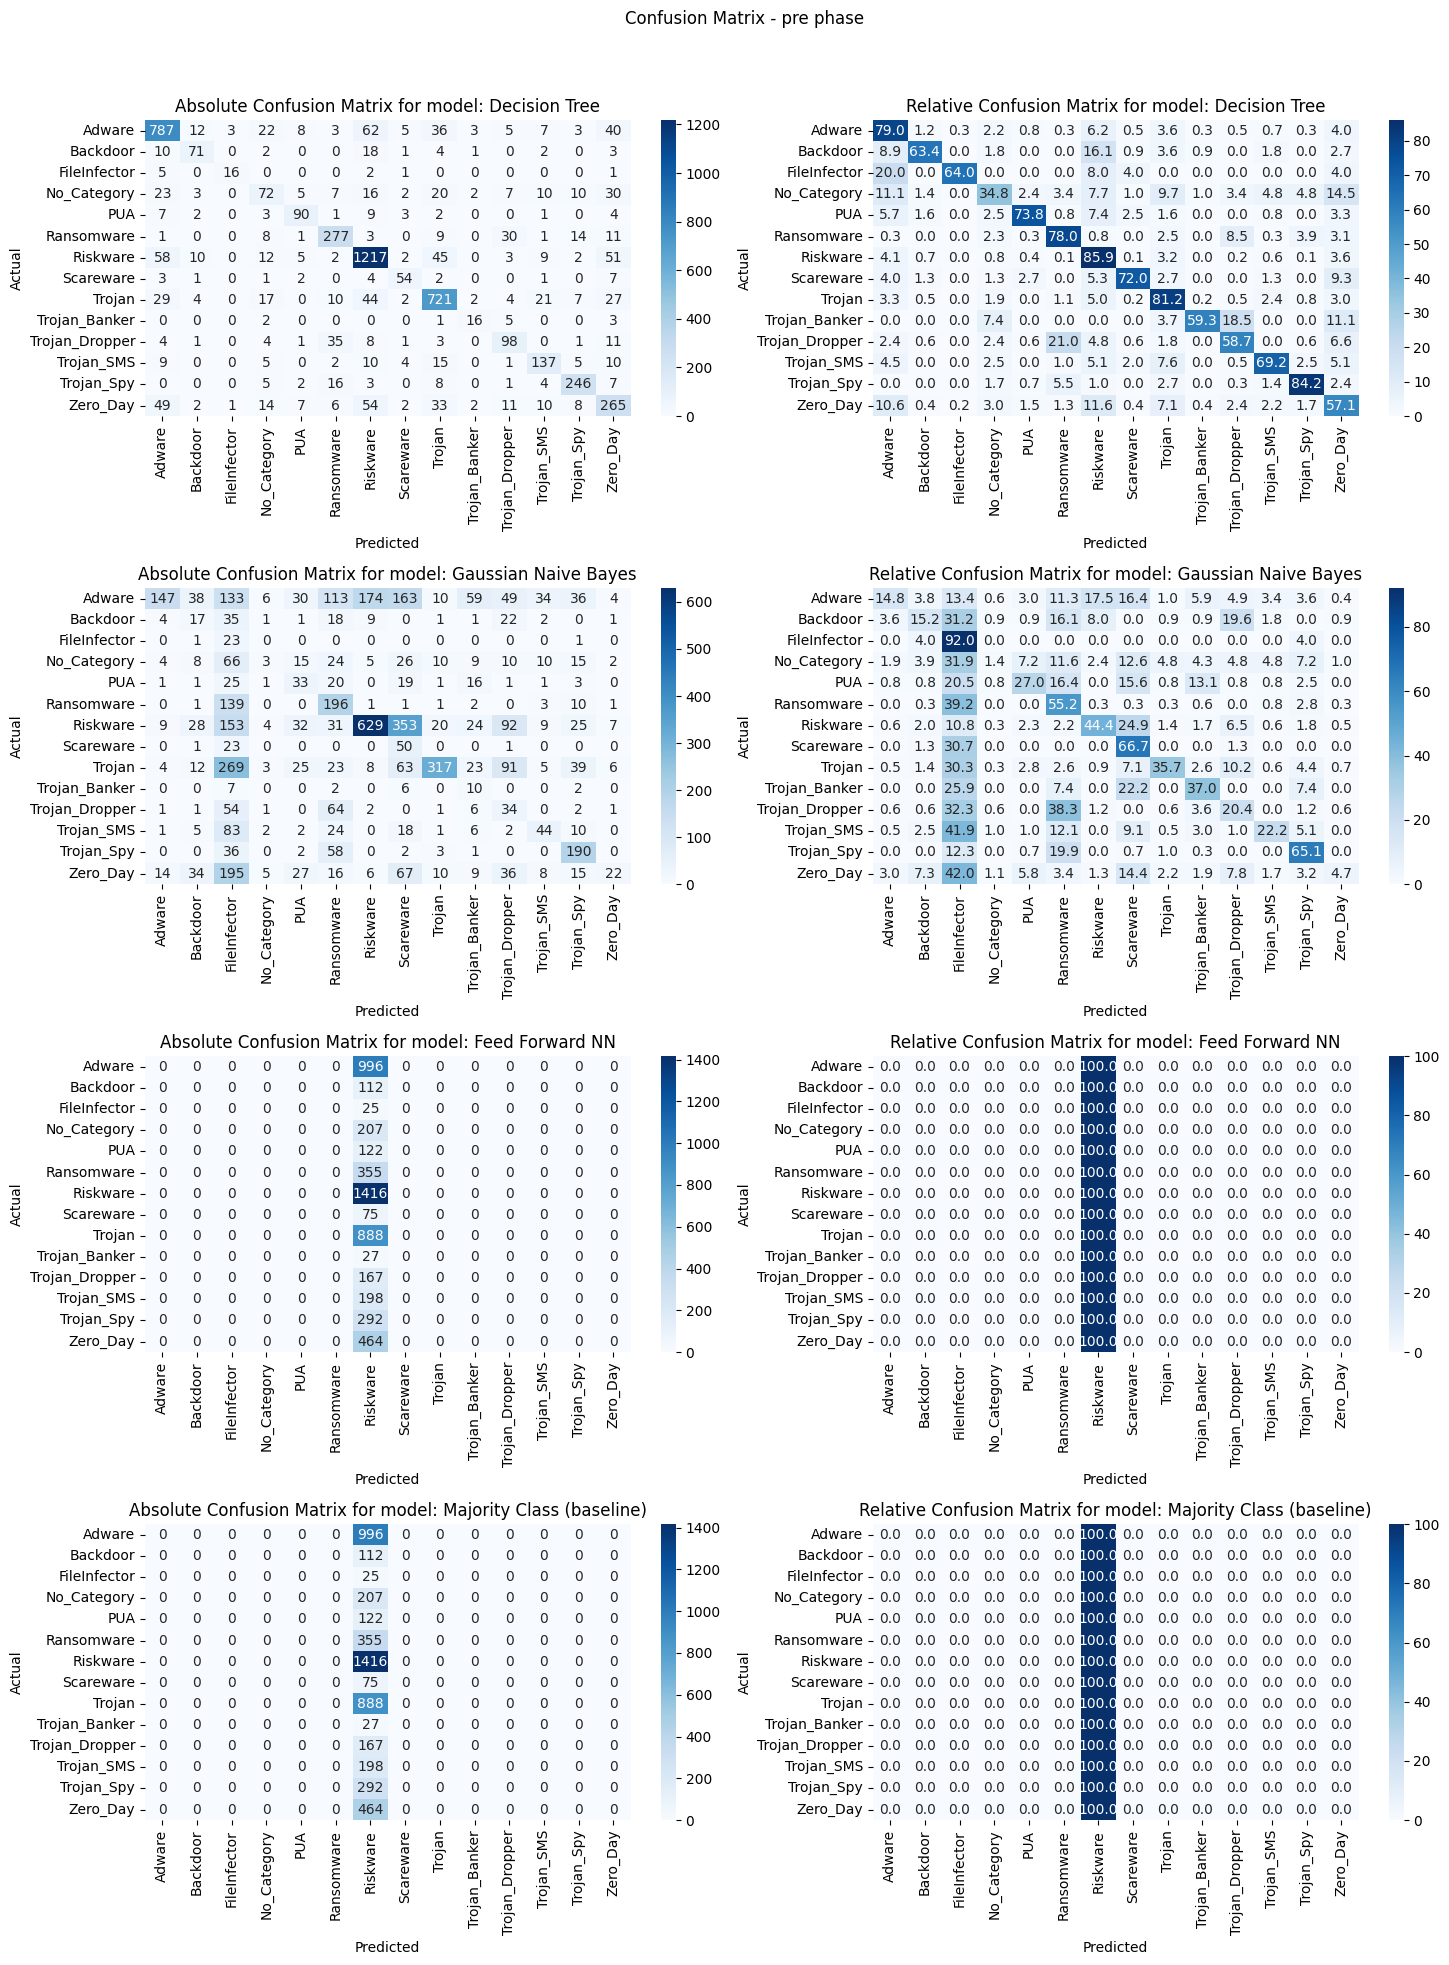

{'tree-based': 32688     8
 42208    12
 46651     8
 27555    13
 37307     6
          ..
 35718     6
 29263     8
 36945     6
 14009     5
 19939     6
 Length: 1277, dtype: int64,
 'naive-bayes': 8718     0
 5961     0
 32688    8
 46651    8
 3727     0
         ..
 19939    6
 33882    3
 20920    6
 32607    8
 38099    6
 Length: 3629, dtype: int64,
 'feedForwardNN': 8718      0
 5961      0
 32688     8
 42208    12
 46651     8
          ..
 43422    12
 33882     3
 33656     3
 32607     8
 8923      0
 Length: 3928, dtype: int64,
 'baselines': 8718      0
 5961      0
 32688     8
 42208    12
 46651     8
          ..
 43422    12
 33882     3
 33656     3
 32607     8
 8923      0
 Length: 3928, dtype: int64}

In [64]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix()
residuals

### Feature importances (pre-tuning)

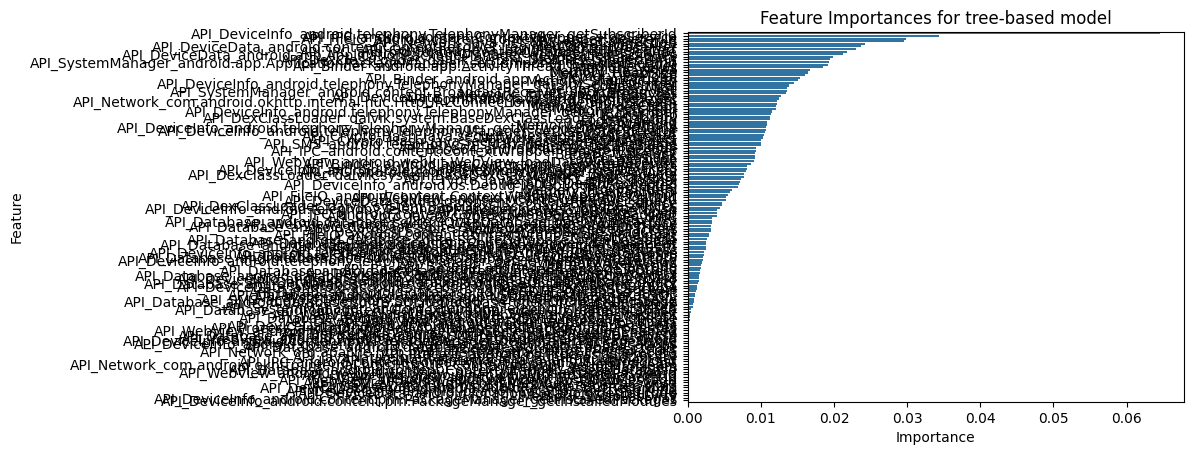

{'tree-based':                                                Feature  Importance
 78   API_DeviceInfo_android.telephony.TelephonyMana...    0.064579
 68   API_IPC_android.content.ContextWrapper_stopSer...    0.034318
 44   API_FileIO_android.content.ContextWrapper_dele...    0.029819
 96             API_Network_java.net.URL_openConnection    0.029593
 3                                  Memory_PrivateDirty    0.024194
 ..                                                 ...         ...
 122  API_DeviceData_android.location.Location_getLo...    0.000000
 121  API_DeviceData_android.location.Location_getLa...    0.000000
 6                                  Memory_SwapPssDirty    0.000000
 95   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 94   API_DeviceInfo_android.content.pm.PackageManag...    0.000000
 
 [142 rows x 2 columns]}

In [65]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance()
importances_dfs

## Hyperparameter Optimization
1. Bind the grids to each model in each pipeline
2. Start all optimizations in parallel

In [68]:
pipeline_manager.pipeline_state = "in"

In [69]:
rf_grid = {
      'n_estimators': [50, 100, 150, 200], 
      'max_depth': [None, 10, 20, 30], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4,]
}

dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]

} 

gnb_grid = {
    'var_smoothing': Real(1e-12, 1e-6, prior='log-uniform')
}


In [70]:
modelNameToOptimizer = {
      "Random Forest": {
            "optimizer_type": "bayes",
            "param_grid": rf_grid,
            "max_iter": 1
      },
      "Decision Tree": {
            "optimizer_type": "bayes",
            "param_grid": dt_grid,
            "max_iter": 1
      },
      "Gaussian Naive Bayes": {
        "optimizer_type": "bayes",
        "param_grid": gnb_grid,
        "max_iter": 1
      }
      }

In [ ]:
optimized_models = pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
                                       current_phase=pipeline_manager.pipeline_state,
                                       modelNameToOptimizer=modelNameToOptimizer)

Lets visualize the resutls of the optimized models

In [ ]:
optimized_models

If you want to see the cross validation progress for a given model you just need to:

In [ ]:
pipeline_manager.pipelines["not-baseline"]["tree-based"].modelling.list_of_models["Decision Tree"].tuning_states["in"].optimizer.cv_tuner.cv_results_

## Stacking Model: Training and Hyperparamter Optimization

In [ ]:
esimtators = []
for pipelineName, results in optimized_models["not-baseline"].items():
      for modelName, modelObject in results.items():
            esimtators.append((modelName, modelObject))

esimtators


In [75]:
# Stacking model
stackingModel = StackingClassifier(
      estimators=esimtators,
      final_estimator=DecisionTreeClassifier(),
      cv=5,
      verbose=3
)

In [76]:
# Stacking
#stacking_pipeline.modelling.add_model("Stacking", stackingModel)

In [77]:
stacking_grid = {
    'final_estimator__max_depth': [10, 20, 30],
    'final_estimator__min_samples_split': [2, 5, 10],
    'final_estimator__min_samples_leaf': [1, 2, 4],
    'final_estimator__max_features': [None, 'sqrt', 'log2'],
    'final_estimator__ccp_alpha': [0.0, 0.01, 0.1],
    'stack_method': ['predict', 'predict_proba'],  
    'passthrough': [False, True]  
}

In [78]:
modelNameToOptimizer = {
      "Stacking": {
            "optimizer_type": "bayes",
            "param_grid":stacking_grid,
            "max_iter": 2
      }
}

In [79]:
# pipeline_manager.all_pipelines_execute(methodName="modelling.fit_models", 
#                                        current_phase=pipeline_manager.pipeline_state,
#                                        modelNameToOptimizer=modelNameToOptimizer)

## Neural Nets: Training and Hyperparameter Optimization

## In-tuning evaluation

In [ ]:
model_results = pipeline_manager.all_pipelines_execute(methodName="modelling.evaluate_and_store_models", 
                                                       exclude_categories=["baseline"],
                                                       comments=comments, 
                                                       current_phase=pipeline_manager.pipeline_state)

### Cross-Model Evaluation (in-tuning)

In [ ]:
pipeline_manager.pipelines_analysis._compute_classification_report().T

In [ ]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision"])

In [ ]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"])
# Note I still have not added a way to extract the fitting time from the in-tuning phase

### Results Summary Visualization

In [ ]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToPredict", performance_metric="accuracy")

### Residual analysis (in-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

In [ ]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix()
residuals

### Feature importances (in-tuning)

In [ ]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance()
importances_dfs

## Optimizer Covergance
Before we proceed, note that you can access the optimizser object (grid, random or bayes) as per shown in the following example. You may see more detailed information on the tuning process there. For now, we limit ourselves to solely plot the convergence map of the bayes optimizer

Questions:
- what can further be analyzed from this process in order to get better insights?

In [ ]:
pipeline_manager.pipelines["not-baseline"]["ensembled"].modelling.list_of_models["Random Forest"].tuning_states["in"].assesment # just an example

In [ ]:
pipeline_manager.all_pipelines_execute(methodName="modelling.plot_convergence")

# Post-tuning Evaluation
Lets start off by selecting the best perfoming model

In [ ]:
best_model, best_score = pipeline_manager.select_best_performing_model(metric="precision")

In [ ]:
pipeline_manager.fit_final_models()

In [ ]:
pipeline_manager.evaluate_store_final_models()

### Metric Evaluation

In [92]:
pipeline_manager.pipeline_state = "post"

### Cross-Model Evaluation (post-tuning)

In [ ]:
class_report_df = pipeline_manager.pipelines_analysis._compute_classification_report(include_training=True)
class_report_df

In [ ]:
pipeline_manager.pipelines_analysis.plot_cross_model_comparison(metric=["f1-score", "recall", "precision"])

In [ ]:
pipeline_manager.pipelines_analysis.plot_results_df(metrics=["timeToFit", "timeToPredict"])


### Results Summary Visualization

In [ ]:
pipeline_manager.pipelines_analysis.plot_results_summary(training_metric="timeToFit", performance_metric="accuracy")

### Intra-model Evaluation (post-tuning)
We plot 3 metrics (f1, recall and precision) for each model constrasting its performance between trainign and validation. It is not subject of interest cross-model evaluation, but rather, intra-model evaluation.

In [ ]:
pipeline_manager.pipelines_analysis.plot_intra_model_comparison(metrics=["f1-score", "recall", "precision"])


### Residual analysis (post-tuning)

This contains the confusion matrices (weighted and not weighted). 
It also returns the specific elements that were erroneously classified. The analysis of this residuals may be meaningful for further inspection (clustering analysis, EDA...)

In [ ]:
residuals, confusion_matrices = pipeline_manager.pipelines_analysis.plot_confusion_matrix()
residuals

### Feature importances (post-tuning)

In [ ]:
importances_dfs = pipeline_manager.pipelines_analysis.plot_feature_importance()
importances_dfs

## Saving Best Model

In [ ]:
pipeline_manager.serialize_models(models_to_serialize=["Majority Class (baseline)"])

In [ ]:
pipeline_manager.serialize_pipelines(pipelines_to_serialize=["naive-bayes"])